RDKit WARNING: [04:23:38] Enabling RDKit 2019.09.3 jupyter extensions


Fragments generated for  CDT-PDI_0
Fragments generated for  CDT-PDI_1
Fragments generated for  CDT-PDI_2
Fragments generated for  CDT-PDI_3
Fragments generated for  CDT-PDI_4
Fragments generated for  CDT-PDI_5
Fragments generated for  CDT-PDI_6
All fragments generated


functional and basis:  b3lyp/6-311g(d,p)
states:  [0]
charges:  [0]
mol_list_name:  CDT-PDI
Raw smiles list:
            name                                      smiles string
0        CDT-PDI  CC(C)n4c(=O)c5ccc6c8ccc9c(=O)n(c3cc2Cc1ccsc1c2...
1     CDT-c2-PDI  CC(C)n4c(=O)c5ccc6c8ccc9c(=O)n(/C=C/c3cc2Cc1cc...
2     CDT-c3-PDI  CC(C)n4c(=O)c5ccc6c8ccc9c(=O)n(C#Cc3cc2Cc1ccsc...
3      CDT-B-PDI  CC(C)n5c(=O)c6ccc7c9ccc%10c(=O)n(c4ccc(c3cc2Cc...
4  CDT-c2-c2-PDI  CC(C)n4c(=O)c5ccc6c8ccc9c(=O)n(/C=C/C=C/c3cc2C...
5  CDT-c3-c3-PDI  CC(C)n4c(=O)c5ccc6c8ccc9c(=O)n(C#CC#Cc3cc2Cc1c...
6    CDT-B-B-PDI  CC(C)n6c(=O)c7ccc8c%10ccc%11c(=O)n(c5ccc(c4ccc...


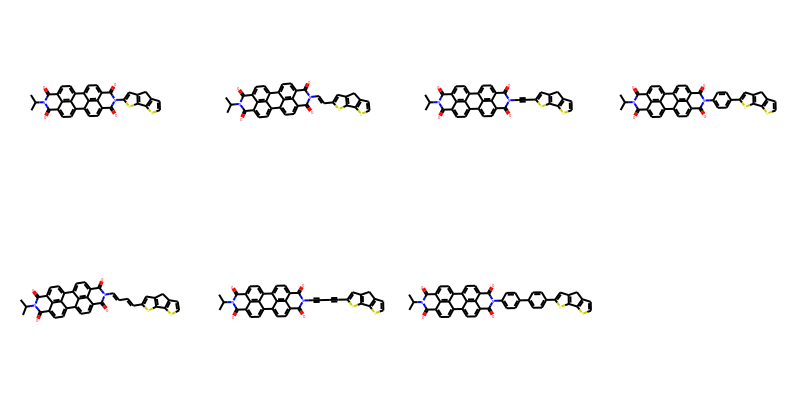

In [1]:
from Gaussain_Dushin_modules import *

#INPUTS ====================================================
input_file = "CDT-PDI"
functional_basis = "b3lyp/6-311g(d,p)"
#functional_basis = "CAM-B3LYP/6-311g(d,p)"

states = [0] 
charges = [0]
#============================================================
#set once for each user ------------------------------------------------------
hostname = 'login.hpc.ic.ac.uk'

username = 'gs920'
password= "Illusions9"

#username = 'ma11115'
#password = 'Baha140821'

project_folder_name = "Stage2/"
#project_folder_name = "george_project/"

#-----------------------------------------------------------------------------




#loading molecules from list
smiles_list = pd.read_csv('/home/inferno/Bsc_Project/chem_structures/'+input_file+".csv")
substructures_list = pd.read_csv('/home/inferno/Bsc_Project/chem_structures/'+input_file+"_substruct.csv")

#converting
input_structures = [Chem.MolFromSmiles(x) for x in smiles_list["smiles string"]]
substructures = [Chem.MolFromSmiles(x) for x in substructures_list['smiles string']]
input_visual=Draw.MolsToGridImage(input_structures,molsPerRow=4,subImgSize=(200,200))
pybel_mol_list = pybel_readsmiles(smiles_list["smiles string"], 3000)


mol_list = input_structures
mol_list_name = input_file  #serial for molecule

#folders

#remote folders
remote_base_folder ="/rds/general/user/"+username+"/home/"
remote_project_folder = remote_base_folder+project_folder_name
remote_bin_path = "PATH="+remote_base_folder+"bin:$PATH"

remote_folder = remote_project_folder+input_file+"/"
remote_theodore_folder = remote_folder+"theodore/"
remote_checkpoint_folder = remote_folder+"checkpoints/" #not in use 

renamed_fb = functional_basis.split("/")[0] + "_" + functional_basis.split("/")[1].split("(")[0]  #renamed functional basis to make it able to be a folder
remote_basis_folder = remote_folder+renamed_fb+"/"

#local folders
base_folder = "../"
xyz_folder = base_folder+"Scripts/xyz_files/"
opt_xyz_folder = base_folder+"Scripts/opt_xyz_files/"
dushin_output_folder = base_folder+"Scripts/dushin_outputs/"
theodore_installation_folder = base_folder+"TheoDORE_3.0/"
theodore_run_folder = base_folder+"Scripts/Theodore_runs/"
sh_output_folder = "/mnt/c/Work/Imperial/Bsc_Project/sh_files/"
theo_sh_folder = sh_output_folder+"theo_sh/"



#Basis set settings
norm_functional_basis = "b3lyp/6-311g(d,p)"



#generating fragments

for mol_num in range(0,len(mol_list)):
    get_fragments(mol_list, mol_list_name, mol_num, substructures, theodore_run_folder)
    print("Fragments generated for ", mol_list_name+"_"+str(mol_num))

print("All fragments generated")
print("\n")




#info about system being ran
print("functional and basis: ", functional_basis)
print("states: ", states)
print("charges: ",charges)

print("mol_list_name: ", mol_list_name)
print("Raw smiles list:")
print(smiles_list)

input_visual

### Checking accuracy of substructure identification

((6, 7, 8, 9, 10, 2, 3, 4, 5),)


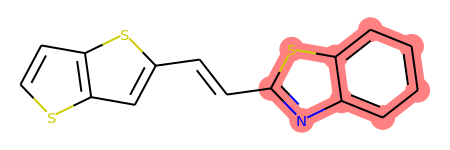

In [5]:
mol_num = 1
m = mol_list[mol_num]
substructure_1 = substructures[mol_num*2]
substructure_2 = substructures[mol_num*2+1]
print(m.GetSubstructMatches(substructure_2))
m

#### Running job from previously optimised geometry

In [4]:
#running job from optimised geometry

status = "Started"
print("Status = ", status)

#conversion from smiles to gjf

#for mol_num in range(0,len(mol_list)):
for mol_num in [1,2,3,4]:
    for state_num in range(0,len(states)):
        charge_state = "C" + str(charges[state_num]) + "S" + str(states[state_num])
        mol_charge_state =  mol_list_name+"_"+str(mol_num)+"_"+charge_state
    
        mol_xyz, n_atoms = get_xyz_optimised(mol_charge_state, opt_xyz_folder, hostname, username, password, remote_folder)
        
        
        gjf_file = generate_Gjf_theodore(mol_list, mol_list_name, mol_xyz, mol_num, states[state_num], charges[state_num])
        generate_shfile_gaussian(walltime='7:59:01', memory="50gb", ncpus=60, timeout="8h", molnumber= mol_num,
                             Excited_state = states[state_num], mollist_name= mol_list, gjf_file=gjf_file)
        run_job_HPC(hostname = hostname, username = username, password = password, remotefolder = remote_theodore_folder,\
                             molnumber = mol_num, Excited_state = states[state_num],mollist_name= mol_list_name, gjf_file= gjf_file)

            
        print("Queued job for: ",gjf_file)
        os.remove(gjf_file+".gjf")
        os.remove(gjf_file+".sh")
        
print("All Jobs uploaded")  



Status =  Started


FileNotFoundError: [Errno 2] No such file